## Set up for multiple practical applications

In [43]:
import numpy as np
import numpy as np
from concrete import fhe
from Bio.Seq import Seq, MutableSeq

import sys, os
sys.path.append(os.path.dirname(os.getcwd()))

from concrete_biopython.FheSeq import FheSeq, FheMutableSeq
from concrete_biopython.SeqWrapper import SeqWrapper


In [44]:
# concatenate sequences from a list and record indices as slices
def gen_seq_indices(seqs):
    slices=[]
    seq=Seq('')
    index=0
    for s in seqs:
        seq = seq+s
        slices.append(slice(index, index+len(s)))
        index+=len(s)
    return seq, slices

In [45]:
SEQ, INDICES = gen_seq_indices([Seq('AB'), Seq('C'), Seq('DEF')])
print(SEQ)

ABCDEF


In [46]:
def slice_seq(seq, slices):
    seqs=[]
    index=0
    for ind in slices:
        seqs.append(seq[ind.start:ind.stop])
    return seqs

In [47]:
def process_seq(seq, lib=fhe):
    seqlist = slice_seq(seq, INDICES)
    return seqlist[0]==seqlist[1]

In [48]:
OUTPUT_PYTHON = process_seq(SEQ, np)
print("Are the first two sequences equal ? : ", OUTPUT_PYTHON)

Are the first two sequences equal ? :  False


In [49]:
# wrap a fhe circuit in order to input and output Bio.Seq objects.
def circuit_wrapper(circuit, seq, simulate=False):
    # convert Seq objects to integers with SeqWrapper.toIntegers
    integers = SeqWrapper(seq).toIntegers()
    # run the circuit with integer inputs
    integer_output = circuit.simulate(integers) if simulate else circuit.encrypt_run_decrypt(integers)
    # convert back the integer outputs into a Seq objects with SeqWrapper.toSeq
    return integer_output

In [50]:
def process_seq_adapter(integer_seq, process_seq):
    # convert integer to FheSeq object, process it and return result as integer array
    return process_seq(FheSeq(integer_seq))

In [66]:
def make_circuit(input_length, process_seq):
    # compile the process_seq_adapter function and create a circuit
    compiler = fhe.Compiler(lambda data: process_seq_adapter(data, process_seq), {"data": "encrypted"})    
    return compiler.compile(
        inputset=[
        np.random.randint(0, SeqWrapper.maxInteger()+1, size=(input_length,))
        for _ in range(100)
        ],
        configuration=fhe.Configuration(
            enable_unsafe_features=True,
            use_insecure_key_cache=True,
            insecure_key_cache_location=".keys",
            dataflow_parallelize=False, # setting it to True makes the jupyter kernel crash
        ),
        verbose=False,
    )

In [67]:
def compute_fhe_output(seq, process_seq, simulate, message):
    output_fhe = circuit_wrapper(make_circuit(len(seq),process_seq), seq, simulate)
    print(message, output_fhe)
    assert(np.all(OUTPUT_PYTHON == output_fhe))
    
compute_fhe_output(SEQ, process_seq, False, 'Are the first two sequences equal ? : ')


Computation Graph
--------------------------------------------------------------------------------
 %0 = data                                             # EncryptedTensor<uint5, shape=(6,)>        ∈ [0, 27]
 %1 = %0[:]                                            # EncryptedTensor<uint5, shape=(6,)>        ∈ [0, 27]
 %2 = zeros()                                          # EncryptedTensor<int3, shape=(6,)>         ∈ [-2, 2]
 %3 = %1[0]                                            # EncryptedScalar<uint5>                    ∈ [0, 27]
 %4 = tlu(%3, table=[ 0  0  0  ...   0  0  0])         # EncryptedScalar<int2>                     ∈ [-1, 1]
 %5 = (%2[0] = %4)                                     # EncryptedTensor<int3, shape=(6,)>         ∈ [-2, 2]
 %6 = %5[0]                                            # EncryptedScalar<int2>                     ∈ [-1, 1]
 %7 = %5[0]                                            # EncryptedScalar<int2>                     ∈ [-1, 1]
 %8 = %1[1]                 

--------------------------------------------------------------------------------

Are the first two sequences equal ? :  2


KeySetCache: miss, regenerating .keys/13369213901258421060/0_0


AssertionError: 

## Computing the hamming distance of sequences

In [55]:
def hamming(dna1, dna2):
    """
    Returns the number of differences between dna1 and dna2.
    """
    return np.sum(dna1 != dna2)

def hamming_adapter(seq1, seq2, lib=fhe):
    """
    Adapter for hamming distance of Seq objects
    """
    if lib is fhe:
        return hamming(seq1.toArray(),seq2.toArray())
    else:
        return hamming(np.array(list(seq1.__str__())), np.array(list(seq2.__str__())))


S = "AGGTTGGTAAAATGGTCCGTGGC"
T = "ACCGTAATAAACGTGTCCGTTGG"


In [56]:
SEQ_H, INDICES_H = gen_seq_indices([S,T])
print(SEQ_H)

AGGTTGGTAAAATGGTCCGTGGCACCGTAATAAACGTGTCCGTTGG


In [57]:
def process_seq(seq, lib=fhe):
    seqlist = slice_seq(seq, INDICES_H)
    return hamming_adapter(seqlist[0],seqlist[1], lib)

In [58]:
OUTPUT_PYTHON = process_seq(SEQ_H, np)
print(f'There are {OUTPUT_PYTHON} differences between S & T.')

There are 10 differences between S & T.


In [59]:
# now we can run our circuit on Seq objects and compare the result with output_seq
compute_fhe_output(SEQ_H, process_seq, False, 'The sorted indices of sequences are : ')


The sorted indices of sequences are :  10


## Finding the origin of replication in a sequence

In [62]:
# Function to find the minimum skew

## FHE LIMITATION: only one minimum can be found

def minimum_skew(seq,lib=fhe):
    if lib is fhe:
        CG_integers = SeqWrapper(Seq('CG')).toIntegers()
        letter_table = [0]*(SeqWrapper.maxInteger()+1)
        letter_table[CG_integers[0]]=-1
        letter_table[CG_integers[1]]=1
        letter_table = fhe.LookupTable(letter_table)
    else:
        letter_table = {'A':0, 'C':-1, 'G':1, 'T':0}
        
    skew_counts = lib.zeros(len(seq))
    skew_counts[0] = letter_table[seq[0]]
    minimum = skew_counts[0]
    min_index = 0
    for i in range(1,len(seq)):
        # compute cumulated sum
        skew_counts[i] = skew_counts[i-1] + letter_table[seq[i]]
        # and keep minimum
        ismin = (skew_counts[i]<minimum)
        minimum = skew_counts[i]*ismin + minimum*(1-ismin)
        min_index = i*ismin + min_index*(1-ismin)
        
    return min_index, skew_counts


In [63]:
SEQ_O = Seq('ACGTGAGGTACGATCGCATACCACTGACGACCATAACCCAGACCACCCCATAGCCAGAGATCGATTGAGATGAGGCCCAGTTAGGGACAG')

OUTPUT_PYTHON, skew_counts = minimum_skew(SEQ_O, np)
print('The minimum skew is at index : ': OUTPUT_PYTHON)

SyntaxError: invalid syntax (1603194846.py, line 4)

Text(0.5, 0, 'Index of DNA')

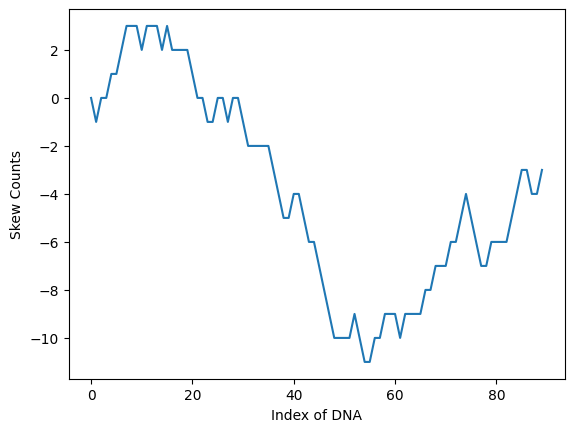

In [64]:
# Plot the skew_counts to check them out
import matplotlib.pyplot as plt
plt.plot(skew_counts)
plt.ylabel('Skew Counts')
plt.xlabel('Index of DNA')

In [65]:
def process_seq(seq, lib=fhe):
    return minimum_skew(seq, lib)[0] # return only the minimum value for fhe

compute_fhe_output(SEQ_O, process_seq, True, 'The minimum skew is at index : ')

The minimum skew is at index :  54


## Sorting sequences

In [33]:
SEQ1 = Seq('AA')
SEQ2 = Seq('AAA')
SEQ3 = Seq('AAB')
SEQ4 = Seq('CAA')

SEQ_S, INDICES_S = gen_seq_indices([SEQ3, SEQ4, SEQ1, SEQ2])
print(SEQ)

AABCAAAAAAA


In [34]:
def sort_rank(seqlist, lib=fhe):
    n=len(seqlist)
    # create comparison matrix
    comp_matrix = lib.zeros((n,n))
    # fill the matrix with results of seqlist[i]>seqlist[j]
    for i in range(0, n):
        for j in range(i+1, n):
            # compute upper half of the matrix
            comp_matrix[i,j] = 1*(seqlist[i]<seqlist[j])
            # then copy the opposite to the lower half because the matrix is antisymetrical
            comp_matrix[j,i] = 1-comp_matrix[i,j] # this counts seqlist[j]>=seqlist[i]
    # now sum up each row to get a sorting rank for the sequences
    return np.sum(comp_matrix, axis=0)
            
     
def process_seq(seq, lib=fhe):
    seqlist = slice_seq(seq, INDICES_S)
    return sort_rank(seqlist, lib)

In [35]:
OUTPUT_PYTHON = process_seq(SEQ_S, np)
print("The sorted indices of sequences are :", OUTPUT_PYTHON)

The sorted indices of sequences are : [2. 3. 0. 1.]


In [36]:
# now we can run our circuit on Seq objects and compare the result with output_seq

simulate = True
OUTPUT_FHE = circuit_wrapper(make_circuit(len(SEQ_S), process_seq), SEQ_S, simulate)
print("The sorted indices of sequences are : ", OUTPUT_FHE)
assert(np.all(OUTPUT_PYTHON == OUTPUT_FHE))


The sorted indices of sequences are :  [2 3 0 1]
